In [2]:
# Data Processing
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import math

In [3]:
# Predicts y_test data according to the given model
def train_and_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train) # Train the model
    predictions = model.predict(X_test) # Make predictions on the test set

    # Removing negative values in predictions
    mask = predictions >= 0
    predictions = predictions[mask]
    y_test = y_test[mask]
    r2 = r2_score(y_test, predictions)
    return predictions, y_test

In [4]:
# Prints statistics of prediction
def print_stats(y_test, predictions):
    print('Mean Squared Error (MSE):', mean_squared_error(y_test, predictions))
    print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, predictions)))
    mape = np.mean(np.abs((y_test - predictions) / np.abs(y_test)))
    print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
    print('Accuracy:', round(100 * (1 - mape), 2))

    correlation_coefficient, p_value = spearmanr(y_test, predictions)
    print(f"\nSpearman Rho:{correlation_coefficient}\np-value:{p_value}")

In [5]:
def merge_identical_xlsx_columns(df, col_name1, col_name2, merged_col_name):
    df[merged_col_name] = df[col_name1].fillna(df[col_name2])
    if merged_col_name == col_name1:
        df.drop(col_name2, axis=1, inplace=True)
    elif merged_col_name == col_name2:
        df.drop(col_name1, axis=1, inplace=True)
    else:
        df.drop([col_name1, col_name2], axis=1, inplace=True)
    return df

In [6]:
# Finds and most reliable Cell lines 
# retrieves a dict cell lines with deviations between doubling of different labs less than diff_pecentage
def get_reliable_cell_lines(df, df2, diff_percentage):
    reliable_cell_lines = {}
    for index, row in df2.iterrows():
        matching_row = df[df['DepMap ID'] == row['Parental cell line ID']] # find correlating row in original data
        if not matching_row.empty:
            original_val = matching_row.iloc[0]['Doubling Time (hrs)'].item()
            ccle_val = row['CCLE Doubling Time (hrs)']
            gpp_val = row['GPP (screeners) Cell Doubling Time (hrs)']
            depmap_val = row['DepMap expansion Doubling time (hrs)']
            
            arr = np.array([original_val, ccle_val, gpp_val, depmap_val])
            arr = arr[~np.isnan(arr)]
            is_min_at_least_percent_of_max = lambda arr: np.min(arr) >= (100-diff_percentage)/100 * np.max(arr)
            if is_min_at_least_percent_of_max(arr):
                reliable_cell_lines[matching_row.iloc[0]['DepMap ID']] = float(np.nanmean(arr))
    return reliable_cell_lines 

Load and Clean Data

In [7]:
# Load original clinical data file
df = pd.read_csv('./DATA/ccle_broad_2019/ccle_broad_2019_clinical_data.csv')
df

,Study ID,Patient ID,Sample ID,Age,Annotation Source,Cancer Type,Cancer Type Detailed,Cell Line Source,Characteristics,DepMap ID,...,Sex,Site of Finding,Site Subtype 1,Site Subtype 2,Site Subtype 3,Subtype,Supplements,TMB (nonsynonymous),Tumor Type,Type Refined
0,ccle_broad_2019,127399_SOFT_TISSUE,127399_SOFT_TISSUE,NaN,NaN,Soft Tissue Sarcoma,Synovial Sarcoma,NaN,NaN,ACH-001270,...,NaN,NaN,NaN,NaN,NaN,Synovial,NaN,5.533333,NaN,NaN
1,ccle_broad_2019,1321N1_CENTRAL_NERVOUS_SYSTEM,1321N1_CENTRAL_NERVOUS_SYSTEM,NaN,CCLE,Glioma,Astrocytoma,NaN,NaN,ACH-001000,...,NaN,NaN,brain,NS,NS,Astrocytoma,NaN,NaN,glioma,glioma
2,ccle_broad_2019,143B_BONE,143B_BONE,13.0,CCLE,Bone Cancer,Osteosarcoma,NaN,NaN,ACH-001001,...,Female,NaN,NS,NS,NS,Osteosarcoma,NaN,NaN,osteosarcoma,osteosarcoma
3,ccle_broad_2019,201T_LUNG,201T_LUNG,NaN,NaN,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,ACH-002089,...,NaN,NaN,NaN,NaN,NaN,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NaN,10.100000,NaN,lung_NSC
4,ccle_broad_2019,22RV1_PROSTATE,22RV1_PROSTATE,NaN,CCLE,Prostate Cancer,Prostate Adenocarcinoma,ATCC,Adherent epithelial,ACH-000956,...,Male,NaN,NS,NS,NS,Adenocarcinoma,NaN,73.700000,prostate,prostate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,ccle_broad_2019,YMB1_BREAST,YMB1_BREAST,63.0,CCLE,Breast Cancer,Invasive Breast Carcinoma,NaN,NaN,ACH-001249,...,Female,NaN,NS,NS,NS,Carcinoma,NaN,NaN,breast,breast
1735,ccle_broad_2019,YT_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YT_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,T-Lymphoblastic Leukemia/Lymphoma,Natural Killer (NK) Cell Lymphoblastic Leukemi...,NaN,NaN,ACH-002317,...,NaN,NaN,NaN,NaN,NaN,Natural Killer Cell Lymphoblastic Leukemia/Lym...,NaN,18.200000,NaN,NaN
1736,ccle_broad_2019,Z138_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Z138_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Mature B-Cell Neoplasms,Mantle Cell Lymphoma,NaN,NaN,ACH-002500,...,NaN,NaN,NaN,NaN,NaN,"B-cell, Non-Hodgkins, Mantle Cell",NaN,NaN,NaN,NaN
1737,ccle_broad_2019,ZR751_BREAST,ZR751_BREAST,63.0,CCLE,Breast Cancer,Invasive Breast Carcinoma,ATCC,adherent epithelial,ACH-000097,...,Female,ascites,NS,NS,NS,Breast Ductal Carcinoma,NaN,8.500000,breast,breast


In [8]:
# Load second clinical data file
df2 = pd.read_excel('./DATA/merged_doubling_time_with_site.xlsx')
df2 = merge_identical_xlsx_columns(df2, "CCLE Doubling Time (hrs)","Doubling.Time.Calculated.hrs",
                                    "CCLE Doubling Time (hrs)")
df2

,Parental cell line ID,Cell Line Name,GPP (screeners) Cell Doubling Time (hrs),DepMap expansion Doubling time (hrs),CCLE Doubling Time (hrs),Site_Primary
0,ACH-000014,Hs294T,66.0,NaN,67.5,skin
1,ACH-000021,NCIH1693,50.0,NaN,94.7,lung
2,ACH-000022,PATU8988S,36.0,NaN,110.0,pancreas
3,ACH-000025,CH157MN,35.0,NaN,NaN,central_nervous_system
4,ACH-000037,S117,45.0,NaN,107.6,soft_tissue
...,...,...,...,...,...,...
1252,ACH-002994,WSUAML,53.0,NaN,NaN,NaN
1253,ACH-003016,TELOHAEC,48.0,NaN,NaN,NaN
1254,ACH-003019,LASCPC01,27.0,NaN,NaN,NaN
1255,ACH-003065,CHLA02ATRT,72.0,NaN,NaN,NaN


In [26]:
reliable_cell_lines = get_reliable_cell_lines(df=df, df2=df2, diff_percentage=30)
len(reliable_cell_lines)
#reliable_cell_lines

619

Note:
df2 contains 3 columns with doubling time:
“GPP (screeners) Cell Doubling Time (hrs)”
“DepMap expansion Doubling time (hrs)”
“CCLE Doubling Time (hrs)”

In [27]:
for cell_line_name, doubling_time in reliable_cell_lines.items():
    matching_row = df[df['DepMap ID'] == cell_line_name] # find correlating row in original data
    if not matching_row.empty:
        df.loc[matching_row.index, 'Doubling Time (hrs)'] = doubling_time

df_cleaned = df.dropna(subset=['Doubling Time (hrs)']) # Clean 'NA' labels
patient_IDs = df_cleaned["Patient ID"].tolist() # who was left after cleaning NA

df_cleaned
#len(patient_IDs) # Only 1092

,Study ID,Patient ID,Sample ID,Age,Annotation Source,Cancer Type,Cancer Type Detailed,Cell Line Source,Characteristics,DepMap ID,...,Sex,Site of Finding,Site Subtype 1,Site Subtype 2,Site Subtype 3,Subtype,Supplements,TMB (nonsynonymous),Tumor Type,Type Refined
0,ccle_broad_2019,127399_SOFT_TISSUE,127399_SOFT_TISSUE,NaN,NaN,Soft Tissue Sarcoma,Synovial Sarcoma,NaN,NaN,ACH-001270,...,NaN,NaN,NaN,NaN,NaN,Synovial,NaN,5.533333,NaN,NaN
2,ccle_broad_2019,143B_BONE,143B_BONE,13.0,CCLE,Bone Cancer,Osteosarcoma,NaN,NaN,ACH-001001,...,Female,NaN,NS,NS,NS,Osteosarcoma,NaN,NaN,osteosarcoma,osteosarcoma
4,ccle_broad_2019,22RV1_PROSTATE,22RV1_PROSTATE,NaN,CCLE,Prostate Cancer,Prostate Adenocarcinoma,ATCC,Adherent epithelial,ACH-000956,...,Male,NaN,NS,NS,NS,Adenocarcinoma,NaN,73.700000,prostate,prostate
5,ccle_broad_2019,2313287_STOMACH,2313287_STOMACH,72.0,CCLE,Esophagogastric Cancer,Stomach Adenocarcinoma,DSMZ,aderent epithelial cells growing as confluent ...,ACH-000948,...,Male,NaN,NS,NS,NS,Adenocarcinoma,NaN,76.266667,stomach,stomach
8,ccle_broad_2019,42MGBA_CENTRAL_NERVOUS_SYSTEM,42MGBA_CENTRAL_NERVOUS_SYSTEM,63.0,CCLE,Glioma,Astrocytoma,DSMZ,Adherent,ACH-000323,...,Male,NaN,brain,NS,NS,Astrocytoma,NaN,7.033333,glioma,glioma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,ccle_broad_2019,YD8_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,46.0,CCLE,Head and Neck Cancer,Oral Cavity Squamous Cell Carcinoma,KCLB,epithelial; monolayer,ACH-000630,...,Female,NaN,mouth,tongue,NS,"Squamous Cell Carcinoma, tongue",25mM Hepes and 25mM NaHCo3,10.800000,upper_aerodigestive,upper_aerodigestive
1731,ccle_broad_2019,YH13_CENTRAL_NERVOUS_SYSTEM,YH13_CENTRAL_NERVOUS_SYSTEM,40.0,CCLE,Glioma,Glioblastoma Multiforme,HSSRB,Adherent,ACH-000469,...,Male,NaN,brain,NS,NS,Glioblastoma,NaN,8.066667,glioma,glioma
1732,ccle_broad_2019,YKG1_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,NaN,CCLE,Glioma,Glioblastoma Multiforme,GNF,NaN,ACH-000570,...,Female,NaN,temporal_lobe,NS,NS,Glioblastoma,NaN,12.066667,glioma,glioma
1737,ccle_broad_2019,ZR751_BREAST,ZR751_BREAST,63.0,CCLE,Breast Cancer,Invasive Breast Carcinoma,ATCC,adherent epithelial,ACH-000097,...,Female,ascites,NS,NS,NS,Breast Ductal Carcinoma,NaN,8.500000,breast,breast


In [28]:
# Load RNA expression data (use Reads Per Kilobase data)
expression_df = pd.read_csv('./DATA/ccle_broad_2019/data_mrna_seq_rpkm.txt',  sep='\t')
expression_df

,Hugo_Symbol,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,...,UMUC16_URINARY_TRACT,UMUC4_URINARY_TRACT,UMUC5_URINARY_TRACT,UMUC6_URINARY_TRACT,UMUC7_URINARY_TRACT,UMUC9_URINARY_TRACT,UPCISCC152_UPPER_AERODIGESTIVE_TRACT,UW228_CENTRAL_NERVOUS_SYSTEM,Y79_AUTONOMIC_GANGLIA,YAMATO_SOFT_TISSUE
0,DDX11L1,0.00000,0.03755,0.00000,0.06507,0.00000,0.01378,0.01463,0.03085,0.00000,...,0.00000,0.02977,0.02999,0.03532,0.03831,0.03236,0.00000,0.03799,0.02907,0.00000
1,WASH7P,12.63011,10.14155,6.20657,6.55835,7.61752,6.19356,4.62277,6.00767,4.70699,...,6.42321,8.17443,7.75149,9.97036,8.17080,8.70551,15.23348,6.47732,8.45568,11.81688
2,MIR1302-11,0.04289,0.01037,0.16955,0.23364,0.08765,0.00000,0.00808,0.09373,0.02568,...,0.12367,0.19183,0.10492,0.18537,0.07408,0.07747,0.07448,0.01049,0.39607,0.17586
3,FAM138A,0.00000,0.00869,0.22423,0.16558,0.00000,0.00637,0.00000,0.01427,0.00000,...,0.01554,0.00459,0.01850,0.04903,0.01330,0.00000,0.02674,0.00879,0.26449,0.02266
4,OR4G4P,0.00000,0.00000,0.02886,0.03875,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00667,0.01182,0.01786,0.01052,0.01141,0.00642,0.00000,0.00000,0.00000,0.01459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56313,MT-ND5,2393.80298,1960.96802,1896.28870,3522.37695,1178.93579,1345.42151,1943.89148,1413.57471,956.31226,...,1994.84985,704.86267,3936.23853,3560.20459,1245.38379,1452.41895,793.58710,757.41357,1218.16992,1320.84558
56314,MT-ND6,1825.52332,2056.64697,2184.88647,4568.00195,1616.96484,1189.86279,1906.90405,1469.75574,1151.82861,...,1260.28455,398.13406,2419.38281,1791.45386,823.17352,996.53717,593.61139,472.01627,729.65912,564.16779
56315,MT-TE,0.25386,0.00000,0.26410,0.00000,0.12970,0.00000,0.00000,0.25217,0.00000,...,1.28093,0.40550,1.22567,1.58799,1.40931,0.08817,0.31489,0.15526,0.55439,0.00000
56316,MT-CYB,4923.78223,3827.00537,1905.18481,4590.01416,2343.92407,1902.01685,2026.15710,1603.98230,2752.73779,...,1585.35229,2027.31738,8521.06738,10211.49121,1641.64551,3437.12769,1645.22168,973.56439,1221.39954,1755.82764


In [29]:
# Remove patients with NA Doubling Time
selected_columns = ['Hugo_Symbol'] + [col for col in patient_IDs if col in expression_df.columns]
expression_df = expression_df[selected_columns]
print(expression_df.head())

  Hugo_Symbol  127399_SOFT_TISSUE  143B_BONE  22RV1_PROSTATE  2313287_STOMACH  \
0     DDX11L1             0.08018    0.00000         0.00000          0.03755   
1      WASH7P             7.22956   11.75542        12.63011         10.14155   
2  MIR1302-11             0.05536    0.36737         0.04289          0.01037   
3     FAM138A             0.00000    0.00932         0.00000          0.00869   
4      OR4G4P             0.01194    0.00000         0.00000          0.00000   

   42MGBA_CENTRAL_NERVOUS_SYSTEM  5637_URINARY_TRACT  639V_URINARY_TRACT  \
0                        0.00000             0.01378             0.03085   
1                        7.61752             6.19356             6.00767   
2                        0.08765             0.00000             0.09373   
3                        0.00000             0.00637             0.01427   
4                        0.00000             0.00000             0.00000   

   647V_URINARY_TRACT  697_HAEMATOPOIETIC_AND_LYMPHOID_T

In [30]:
 # sort by patient ID
expression_df_sorted = expression_df[expression_df.columns[0]].to_frame().join(expression_df[expression_df.columns[1:]].sort_index(axis=1))
df_cleaned_sorted = df_cleaned.sort_values(by='Patient ID')
df_cleaned_sorted

,Study ID,Patient ID,Sample ID,Age,Annotation Source,Cancer Type,Cancer Type Detailed,Cell Line Source,Characteristics,DepMap ID,...,Sex,Site of Finding,Site Subtype 1,Site Subtype 2,Site Subtype 3,Subtype,Supplements,TMB (nonsynonymous),Tumor Type,Type Refined
0,ccle_broad_2019,127399_SOFT_TISSUE,127399_SOFT_TISSUE,NaN,NaN,Soft Tissue Sarcoma,Synovial Sarcoma,NaN,NaN,ACH-001270,...,NaN,NaN,NaN,NaN,NaN,Synovial,NaN,5.533333,NaN,NaN
2,ccle_broad_2019,143B_BONE,143B_BONE,13.0,CCLE,Bone Cancer,Osteosarcoma,NaN,NaN,ACH-001001,...,Female,NaN,NS,NS,NS,Osteosarcoma,NaN,NaN,osteosarcoma,osteosarcoma
4,ccle_broad_2019,22RV1_PROSTATE,22RV1_PROSTATE,NaN,CCLE,Prostate Cancer,Prostate Adenocarcinoma,ATCC,Adherent epithelial,ACH-000956,...,Male,NaN,NS,NS,NS,Adenocarcinoma,NaN,73.700000,prostate,prostate
5,ccle_broad_2019,2313287_STOMACH,2313287_STOMACH,72.0,CCLE,Esophagogastric Cancer,Stomach Adenocarcinoma,DSMZ,aderent epithelial cells growing as confluent ...,ACH-000948,...,Male,NaN,NS,NS,NS,Adenocarcinoma,NaN,76.266667,stomach,stomach
8,ccle_broad_2019,42MGBA_CENTRAL_NERVOUS_SYSTEM,42MGBA_CENTRAL_NERVOUS_SYSTEM,63.0,CCLE,Glioma,Astrocytoma,DSMZ,Adherent,ACH-000323,...,Male,NaN,brain,NS,NS,Astrocytoma,NaN,7.033333,glioma,glioma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,ccle_broad_2019,YD8_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,46.0,CCLE,Head and Neck Cancer,Oral Cavity Squamous Cell Carcinoma,KCLB,epithelial; monolayer,ACH-000630,...,Female,NaN,mouth,tongue,NS,"Squamous Cell Carcinoma, tongue",25mM Hepes and 25mM NaHCo3,10.800000,upper_aerodigestive,upper_aerodigestive
1731,ccle_broad_2019,YH13_CENTRAL_NERVOUS_SYSTEM,YH13_CENTRAL_NERVOUS_SYSTEM,40.0,CCLE,Glioma,Glioblastoma Multiforme,HSSRB,Adherent,ACH-000469,...,Male,NaN,brain,NS,NS,Glioblastoma,NaN,8.066667,glioma,glioma
1732,ccle_broad_2019,YKG1_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,NaN,CCLE,Glioma,Glioblastoma Multiforme,GNF,NaN,ACH-000570,...,Female,NaN,temporal_lobe,NS,NS,Glioblastoma,NaN,12.066667,glioma,glioma
1737,ccle_broad_2019,ZR751_BREAST,ZR751_BREAST,63.0,CCLE,Breast Cancer,Invasive Breast Carcinoma,ATCC,adherent epithelial,ACH-000097,...,Female,ascites,NS,NS,NS,Breast Ductal Carcinoma,NaN,8.500000,breast,breast


In [31]:
# Get all column names except for the first one and store them in a list
patient_ID_list = expression_df_sorted.columns[1:].tolist()

# Filter out rows where 'Patient ID' is not in the allowed list
df_cleaned_sorted_filtered = df_cleaned_sorted[df_cleaned_sorted['Patient ID'].isin(patient_ID_list)]

num_rows, num_columns = df_cleaned_sorted_filtered.shape
print(f'Successfully loaded data.\nNumber of rows:{num_rows}\nNumber of columns:{num_columns-1}')
print(df_cleaned_sorted_filtered.head())

Successfully loaded data.
Number of rows:868
Number of columns:50
          Study ID                     Patient ID  \
0  ccle_broad_2019             127399_SOFT_TISSUE   
2  ccle_broad_2019                      143B_BONE   
4  ccle_broad_2019                 22RV1_PROSTATE   
5  ccle_broad_2019                2313287_STOMACH   
8  ccle_broad_2019  42MGBA_CENTRAL_NERVOUS_SYSTEM   

                       Sample ID   Age Annotation Source  \
0             127399_SOFT_TISSUE   NaN               NaN   
2                      143B_BONE  13.0              CCLE   
4                 22RV1_PROSTATE   NaN              CCLE   
5                2313287_STOMACH  72.0              CCLE   
8  42MGBA_CENTRAL_NERVOUS_SYSTEM  63.0              CCLE   

              Cancer Type     Cancer Type Detailed Cell Line Source  \
0     Soft Tissue Sarcoma         Synovial Sarcoma              NaN   
2             Bone Cancer             Osteosarcoma              NaN   
4         Prostate Cancer  Prostate Adeno

In [32]:
# Prepare counts
counts = expression_df_sorted
counts = counts.set_index('Hugo_Symbol')
counts = counts[counts.sum(axis=1) > 0]   #remove rows containing only 0

# Transpose the DataFrame to have samples as rows and genes as columns
counts = counts.T #(=x.train)

# prepare metadata (=y.train)
metadata = pd.DataFrame(zip(counts.index, df_cleaned_sorted_filtered['Doubling Time (hrs)']),
                        columns=['Sample', 'Doubling Time (hrs)'])
metadata = metadata.set_index('Sample')
metadata

,Doubling Time (hrs)
Sample,
127399_SOFT_TISSUE,44.000000
143B_BONE,46.000000
22RV1_PROSTATE,58.400000
2313287_STOMACH,97.600000
42MGBA_CENTRAL_NERVOUS_SYSTEM,82.600000
...,...
YD8_UPPER_AERODIGESTIVE_TRACT,48.000000
YH13_CENTRAL_NERVOUS_SYSTEM,70.388889
YKG1_CENTRAL_NERVOUS_SYSTEM,39.400000


Get Features (Genes)

In [33]:
genes, rhos, pvals = [], [], []
# Loop through each gene column
for gene_idx in range(counts.shape[1]):
    # Extract the gene expression levels for the current gene
    gene_expression = counts.iloc[:, gene_idx].tolist()

    # Calculate correlation and p-value (PEARSON corr between gene expression and doubling time)
    correlation_coefficient, p_value = pearsonr(gene_expression, metadata['Doubling Time (hrs)'].tolist())

    if abs(correlation_coefficient) >= 0.38 and p_value <= 0.05:
        genes.append(counts.columns[gene_idx])
        pvals.append(p_value)
        rhos.append(correlation_coefficient)

chosen_genes_expression = counts[counts.columns[counts.columns.isin(genes)]]
genes

# add the doubling time as a column in the df
#chosen_genes_expression['Doubling Time (hrs)'] = metadata['Doubling Time (hrs)']

['RN7SL503P',
 'MANEAL',
 'MIR5008',
 'RP11-64C1.1',
 'CTD-2296D1.1',
 'CTD-2296D1.5',
 'RP11-136H13.1',
 'RP11-134L4.2',
 'RP11-15G8.1']

Train Models and Predict

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(chosen_genes_expression, metadata['Doubling Time (hrs)'], test_size=0.2, random_state=42)

In [35]:
############## Random Forest ##############
print("\n--- Random Forest ---\n")
rf_model = RandomForestRegressor(random_state=42) # n_estimators=100
predictions, y_test = train_and_predict(rf_model, X_train, X_test, y_train, y_test)

print_stats(np.log10(y_test), np.log10(predictions))


--- Random Forest ---
Mean Squared Error (MSE): 0.08488164225125519
Root Mean Squared Error (RMSE): 0.291344542168298
Mean Absolute Percentage Error (MAPE): 13.28
Accuracy: 86.72

Spearman Rho:0.0885499304860658
p-value:0.2452684755255846


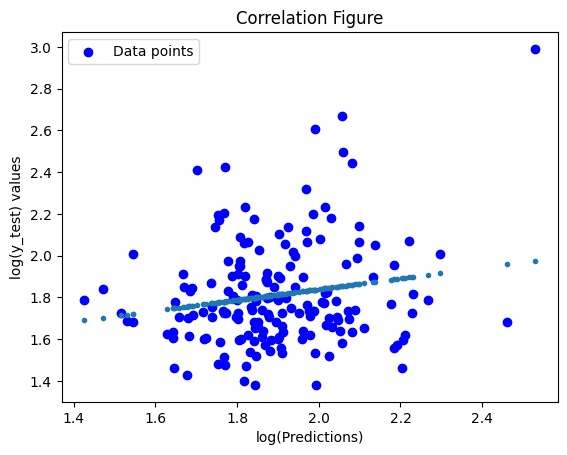

In [36]:
# Correlation Figure
plt.scatter(np.log10(predictions), np.log10(y_test), color='blue', label='Data points')
b, m = polyfit(np.log10(predictions), np.log10(y_test), 1) # Fit with polyfit
plt.plot(np.log10(predictions), b + m * np.log10(predictions), '.')
plt.xlabel('log(Predictions)')
plt.ylabel('log(y_test) values')
plt.title('Correlation Figure')
plt.legend()
plt.show()

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(chosen_genes_expression, metadata['Doubling Time (hrs)'], test_size=0.2, random_state=42)

In [38]:
############## Linear Regression ##############
print("\n--- Linear Regression ---\n")
lr_model = LinearRegression()
predictions, y_test = train_and_predict(lr_model, X_train, X_test, y_train, y_test)

print_stats(np.log10(y_test), np.log10(predictions))


--- Linear Regression ---

Mean Squared Error (MSE): 0.06711165130040544
Root Mean Squared Error (RMSE): 0.25905916563674297
Mean Absolute Percentage Error (MAPE): 12.41
Accuracy: 87.59

Spearman Rho:0.16871404283202465
p-value:0.0260525294615403


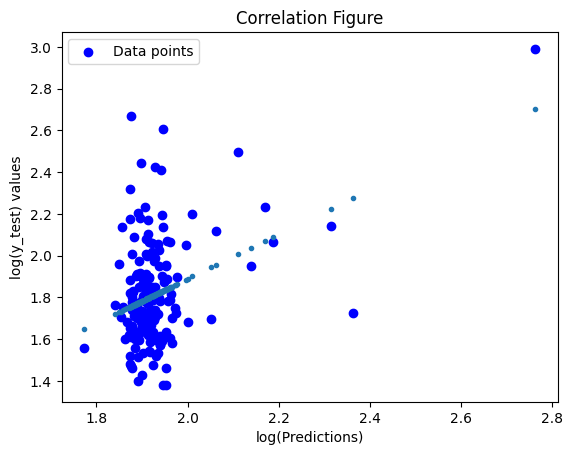

In [39]:
# Correlation Figure

plt.scatter(np.log10(predictions), np.log10(y_test), color='blue', label='Data points')
b, m = polyfit(np.log10(predictions), np.log10(y_test), 1) # Fit with polyfit
plt.plot(np.log10(predictions), b + m * np.log10(predictions), '.')
plt.xlabel('log(Predictions)')
plt.ylabel('log(y_test) values')
plt.title('Correlation Figure')
plt.legend()
plt.show()